# Interacting with GEE through the GEEInterface

<center>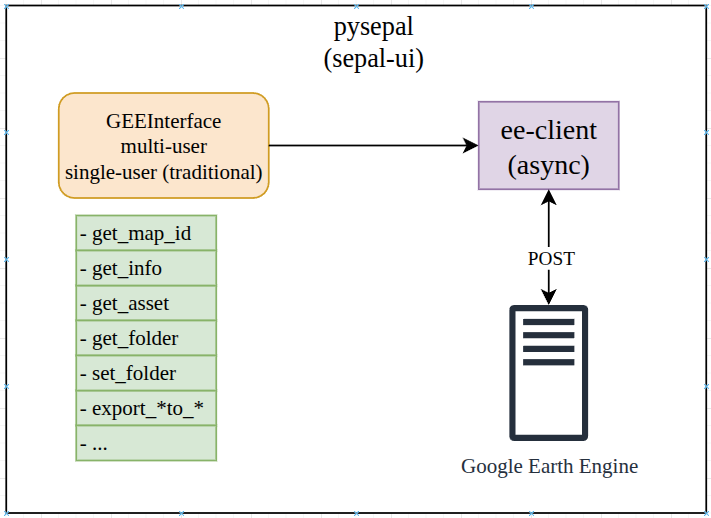</center>

# Initialize GEE

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import ee
from sepal_ui.scripts.utils import init_ee

init_ee()

In [ ]:
ee.data._cloud_api_user_project

In [ ]:
ee_object_number = ee.Number(5)
# non-computed object
ee_object_number

In [ ]:
ee_object_number.serialize()

# Initialize GEE Interface from sepal headers

In [ ]:
from sepal_ui.scripts.gee_interface import GEEInterface
from eeclient.helpers import get_sepal_headers_from_auth
from eeclient.client import EESession
import os
import logging
from ee import serializer
from pathlib import Path
import json

In [ ]:
logger = logging.getLogger("sepalui")
logger.setLevel(logging.INFO)
console_handler = logging.StreamHandler()
logger.addHandler(console_handler)

In [ ]:
# Store these environment variables in your system
sepal_username = os.getenv("SEPAL_USER")
sepal_password = os.getenv("SEPAL_PASSWORD")
sepal_host = "sepal.io"

sepal_headers = get_sepal_headers_from_auth(sepal_username, sepal_password, sepal_host)

In [ ]:
ee_session = EESession(sepal_headers)

In [ ]:
gee_interface = GEEInterface(session=ee_session)

In [ ]:
# Note that we are using a different user/project
gee_interface.session.project_id

### > Compute values with ee objects

In [ ]:
# Instead of doing ee.Number(5).getInfo(), we do:
gee_interface.get_info(ee.Number(5))

## > Compute values with serialized objects

In [ ]:
# https://code.earthengine.google.com/283fd3558428629ba18fe00628be4862
text_obj = Path("long_calculation").read_text()
serialized_obj = json.loads(json.loads(text_obj))

In [ ]:
gee_interface.get_info(serialized_object=serialized_obj)

## > Await asynchronous calls

In [ ]:
await gee_interface.get_folder_async()

In [ ]:
# Our use the sync call
gee_interface.get_folder()

In [ ]:
future = gee_interface.create_task(
    gee_interface.get_info_async,
).start(100020)

In [ ]:
future.result()

# Create and await multiple tasks

In [ ]:
from random import randint
import asyncio

In [ ]:
# create ee_objects
numbers = [randint(0, 420) for _ in range(5)]
ee_objects = [ee.Number(n) for n in numbers]

In [ ]:
# Synchronous batch method (blocks until all complete)
results = gee_interface.get_info_batch(ee_objects)
results

In [ ]:
# Or asynchronous batch method using create_task
task = gee_interface.create_task(gee_interface.get_info_batch_async)
future = task.start(ee_objects)

In [ ]:
future.result()

## Compute map_id

In [ ]:
bogota = [4.9, -74.13]

aoi = ee.Geometry.Polygon([[[-74.2, 4.8], [-74.0, 4.8], [-74.0, 4.6], [-74.2, 4.6]]])

srtm = ee.Image("USGS/SRTMGL1_003")
polygons = ee.FeatureCollection(
    [
        ee.Feature(ee.Geometry.Rectangle([-74.15, 4.77, -74.10, 4.72]), {"name": "Tile A"}),
        ee.Feature(ee.Geometry.Rectangle([-74.09, 4.77, -74.04, 4.72]), {"name": "Tile B"}),
    ]
)

s2 = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterBounds(polygons)
    .filterDate("2024-01-01", "2024-12-31")
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 10))
    .median()
)

# Compute NDVI
ndvi = s2.normalizedDifference(["B8", "B4"]).rename("NDVI")

In [ ]:
map_id_dict = gee_interface.get_map_id(ndvi)
map_id_dict

# UI components

In [ ]:
from ipyleaflet import TileLayer, Map

# Create the layer
tile_layer = TileLayer(
    url=map_id_dict["tile_fetcher"].url_format,
    attribution="Google Earth Engine",
    name="test",
    max_zoom=24,
)

In [ ]:
map_ = Map(center=bogota)

In [ ]:
map_.add(tile_layer)

In [ ]:
# or using sepal_ui
from sepal_ui.mapping import SepalMap

In [ ]:
sepal_map = SepalMap()

In [ ]:
sepal_map

In [ ]:
await sepal_map.add_ee_layer_async(ndvi)
sepal_map.center = bogota
sepal_map.zoom = 10

## TaskButton

In [ ]:
from sepal_ui.sepalwidgets.btn import TaskButton
from sepal_ui.scripts.gee_interface import GEEInterface
from sepal_ui.scripts.utils import init_ee
import ee
import asyncio
import ipyvuetify as v

init_ee()

In [ ]:
button = TaskButton("long task", small=True)

In [ ]:
async def wait(seconds):
    sepal_map.remove_all()
    await asyncio.sleep(1.5)
    await sepal_map.add_ee_layer_async(ndvi)

In [ ]:
def configure_task():
    return gee_interface.create_task(
        wait,
        key="mytask",
    )

In [ ]:
button.configure(
    task_factory=configure_task,
    start_args=(2,),
)

In [ ]:
button

## AssetSelect

In [ ]:
from sepal_ui.sepalwidgets.inputs import AssetSelect

In [ ]:
asset_select = AssetSelect(
    gee_interface=gee_interface,
    types=["IMAGE_COLLECTION"],
)

In [ ]:
asset_select